In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

import glob
from scipy import interpolate
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

!whoami

ihme\yongqx2


In [2]:
%cd C:/Users/yongqx2/Desktop/Sim Science/Swiss RE Cancer/forecasts
#%cd /ihme/costeffectiveness/vivarium_csu_cancer

C:\Users\yongqx2\Desktop\Sim Science\Swiss RE Cancer\forecasts


In [3]:
forecast_names = glob.glob('*forecast*.csv')
forecast = {}
for forecast_name in forecast_names:
    forecast[forecast_name[:-4]] = (pd.read_csv(forecast_name)
                                 .drop(columns=['location', 'age_group_id', 'sex_id'])
                                 .rename(columns={'year_id': 'year'}))

In [4]:
forecast.keys()

dict_keys(['acmr_forecast', 'c429_csmr_forecast', 'c429_incidence_forecast', 'c429_prev_forecast'])

In [5]:
incidence = forecast['c429_incidence_forecast']
incidence

,year,age,sex,mean,lb,ub
0,2020,15 to 19,male,0.055150,0.045545,0.068971
1,2020,15 to 19,female,0.278463,0.231600,0.334534
2,2020,20 to 24,male,0.054776,0.047745,0.062537
3,2020,20 to 24,female,1.226677,1.047347,1.426381
...,...,...,...,...,...,...
676,2039,90 to 94,male,3.483799,2.115589,5.475939
677,2039,90 to 94,female,159.153533,91.395481,261.059379
678,2039,95 plus,male,4.264335,2.155689,7.765110
679,2039,95 plus,female,166.423566,101.230557,262.519909


In [6]:
incidence['age_midpoint'] = incidence['age'].map(lambda x: int(x.split(' ')[0]) + 2)
incidence

,year,age,sex,mean,lb,ub,age_midpoint
0,2020,15 to 19,male,0.055150,0.045545,0.068971,17
1,2020,15 to 19,female,0.278463,0.231600,0.334534,17
2,2020,20 to 24,male,0.054776,0.047745,0.062537,22
3,2020,20 to 24,female,1.226677,1.047347,1.426381,22
...,...,...,...,...,...,...,...
676,2039,90 to 94,male,3.483799,2.115589,5.475939,92
677,2039,90 to 94,female,159.153533,91.395481,261.059379,92
678,2039,95 plus,male,4.264335,2.155689,7.765110,97
679,2039,95 plus,female,166.423566,101.230557,262.519909,97


In [7]:
def interp(x, y, xnew):
    f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
    ynew = f(xnew)
    ynew = list(map(lambda x: 0 if x < 0 else x, ynew))
    return ynew

In [8]:
def age_interp(data: pd.DataFrame):
    df = pd.DataFrame()
    x = np.arange(15, 105)
    for year in range(2020, 2040):
        for sex in ['male', 'female']:
            data_sub = data[(data.year == year) & (data.sex == sex)]
            y = interp(data_sub['age_midpoint'], data_sub['mean'], x)
            t = pd.DataFrame({'age': x, 'mean': y})
            t['year'] = year
            t['sex'] = sex
            df = df.append(t)
    return df

In [9]:
t = age_interp(incidence)
t

,age,mean,year,sex
0,15,0.055299,2020,male
1,16,0.055224,2020,male
2,17,0.055150,2020,male
3,18,0.055075,2020,male
...,...,...,...,...
86,101,172.239592,2039,female
87,102,173.693598,2039,female
88,103,175.147605,2039,female
89,104,176.601612,2039,female


In [10]:
# check 20200706_breast_cancer_model_3_output_processing.ipynb for how calculate the breast cancer incidence in sim baseline
sim_incidence = pd.read_csv(
'C:/Users/yongqx2/Desktop/Sim Science/Swiss RE Cancer/breast_cancer_incidence_from_sim_baseline.csv'
).iloc[:, 1:]

sim_incidence = sim_incidence[['age_cohort', 'sex', 'year', 'mean']]
sim_incidence['age_midpoint'] = list(map(lambda x, y: y - int(x.split('_to_')[1]) + 2, 
                                     sim_incidence['age_cohort'], sim_incidence['year']))
sim_incidence

,age_cohort,sex,year,mean,age_midpoint
0,1935_to_1940,female,2020,78.664023,82
1,1935_to_1940,female,2021,69.907477,83
2,1935_to_1940,female,2022,61.946741,84
3,1935_to_1940,female,2023,54.966637,85
...,...,...,...,...,...
542,2000_to_2005,male,2035,0.053370,32
543,2000_to_2005,male,2036,0.045361,33
544,2000_to_2005,male,2037,0.072122,34
545,2000_to_2005,male,2038,0.052107,35


In [11]:
# breast cancer incidence in sim vs forecast by year
def sim_vs_forecast_by_year(sim, forecast, age: int, sex: str):
    sim_sub = sim[(sim.age_midpoint == age) & (sim.sex == sex)]
    forecast_sub = forecast[(forecast.age == age) & (forecast.sex == sex)]
    
    plt.figure(figsize=(6, 4), dpi=120)  
    plt.plot(sim_sub['year'], sim_sub['mean'], marker='o', label='sim')
    plt.plot(forecast_sub['year'], forecast_sub['mean'], marker='o', label='forecast')
    plt.title(f'{sex}, {age}')
    plt.xlabel('Year')
    plt.margins(0.1)
    plt.ylabel('Breast cancer incidence\n (Cases per 100,000 PY)')
    plt.legend(loc=(1.05, .1))
    plt.grid()

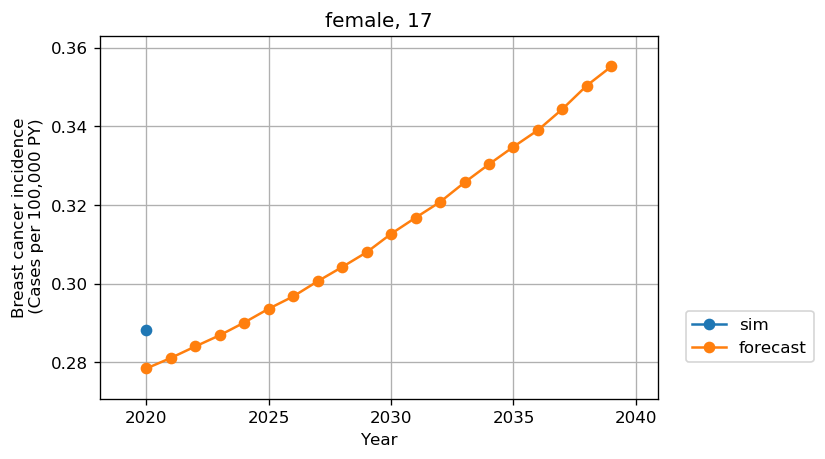

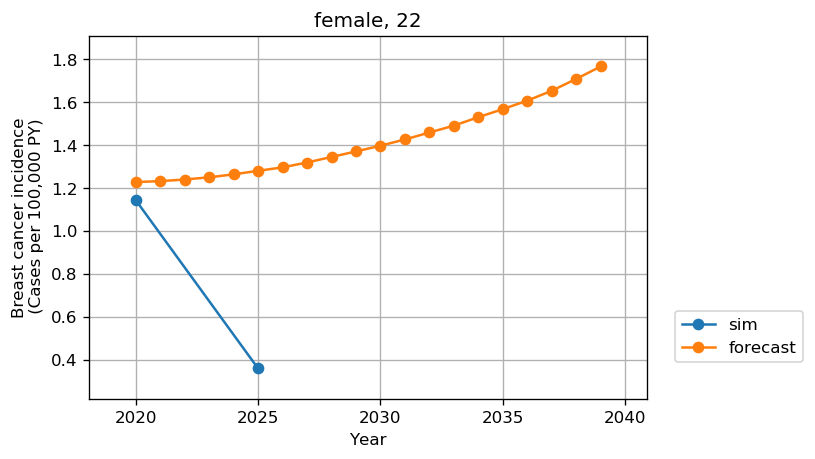

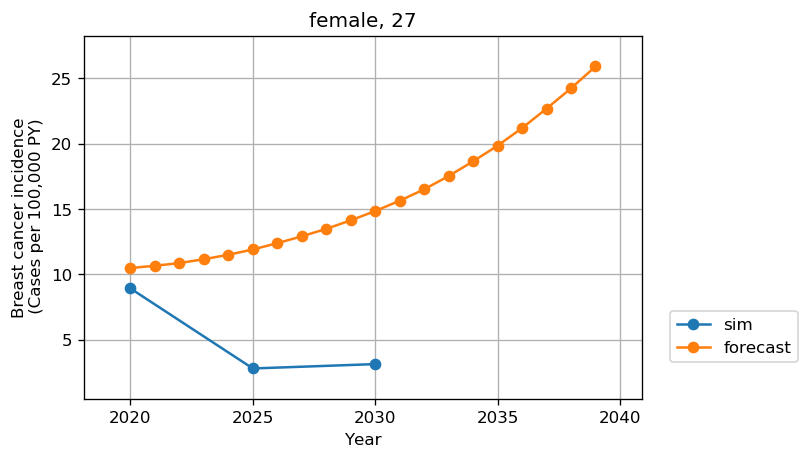

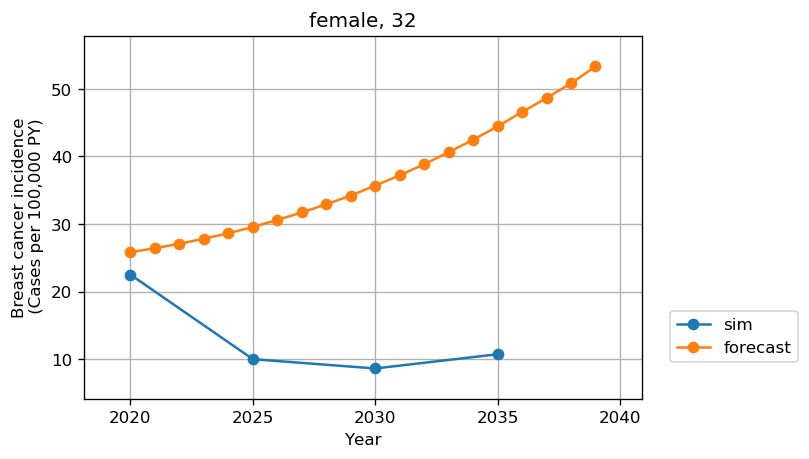

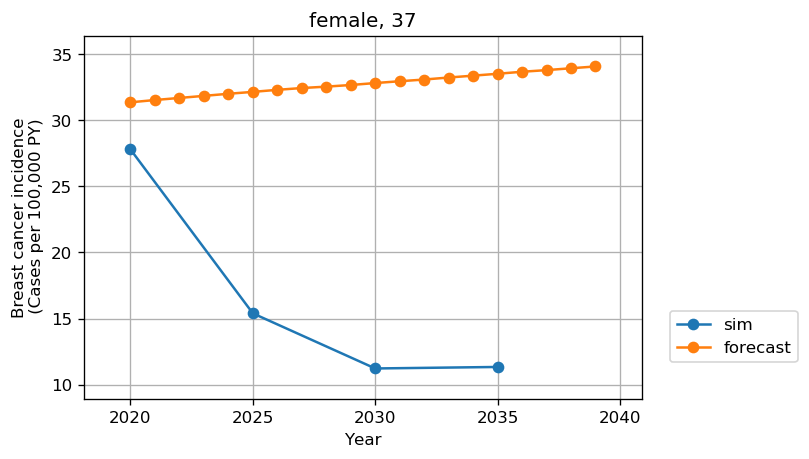

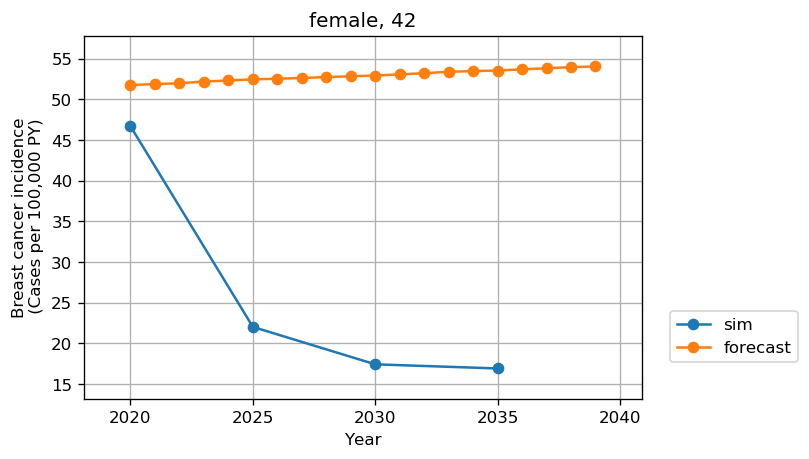

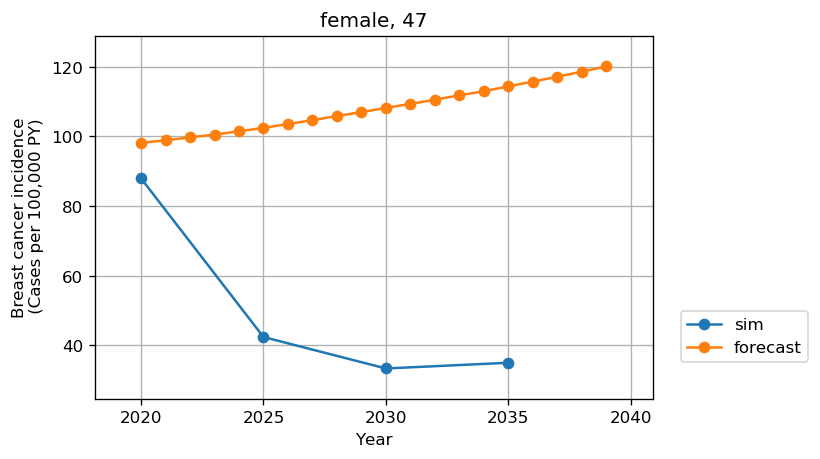

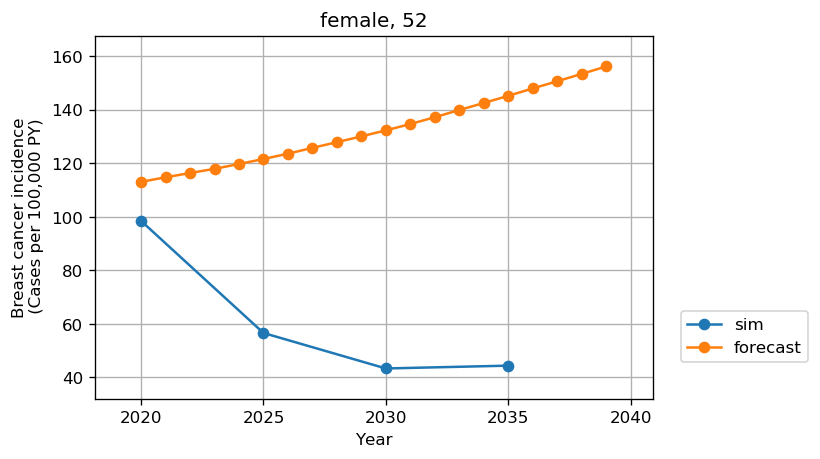

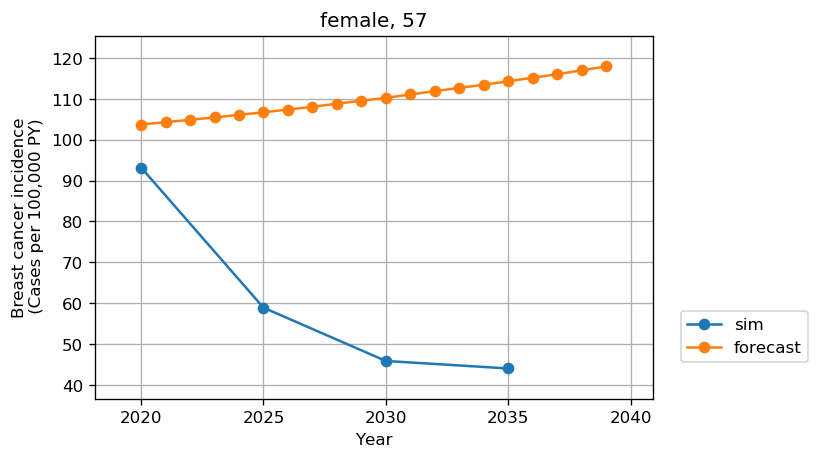

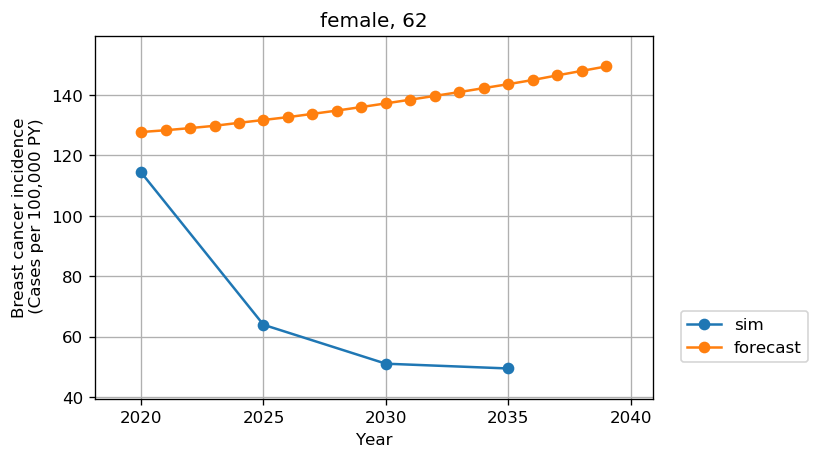

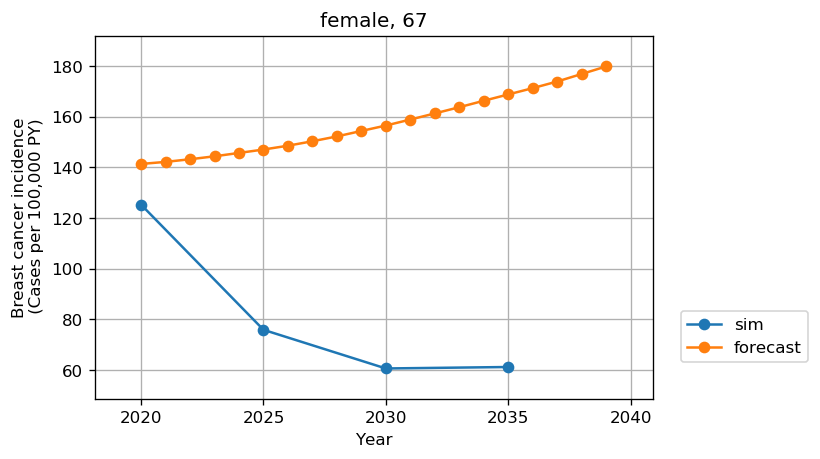

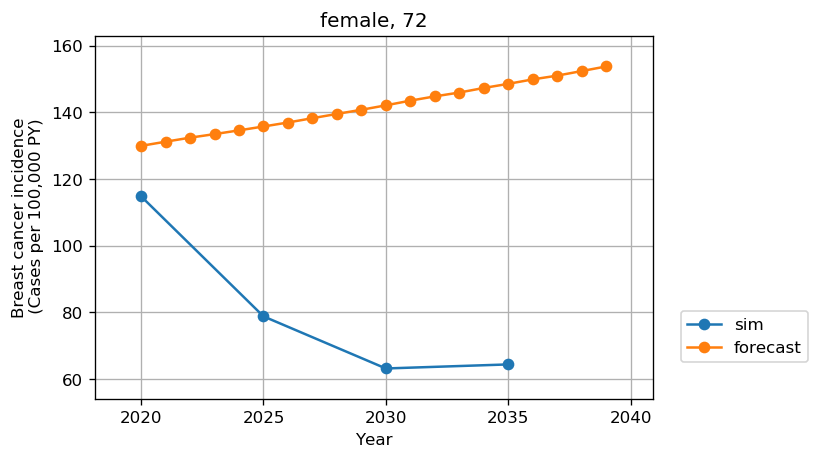

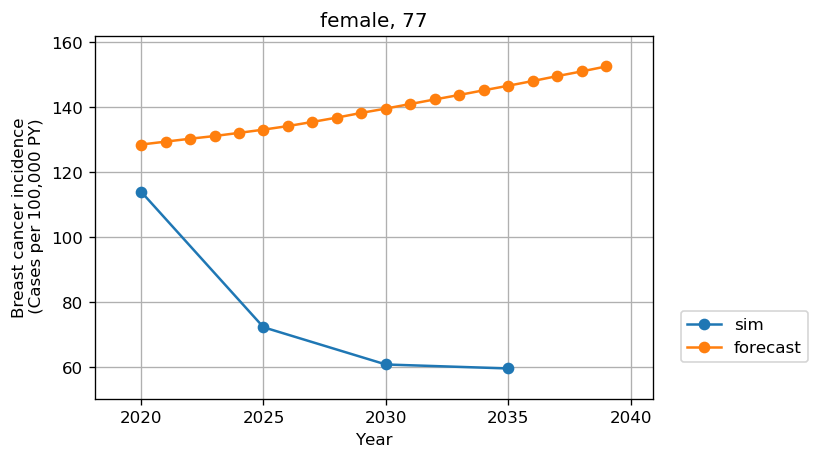

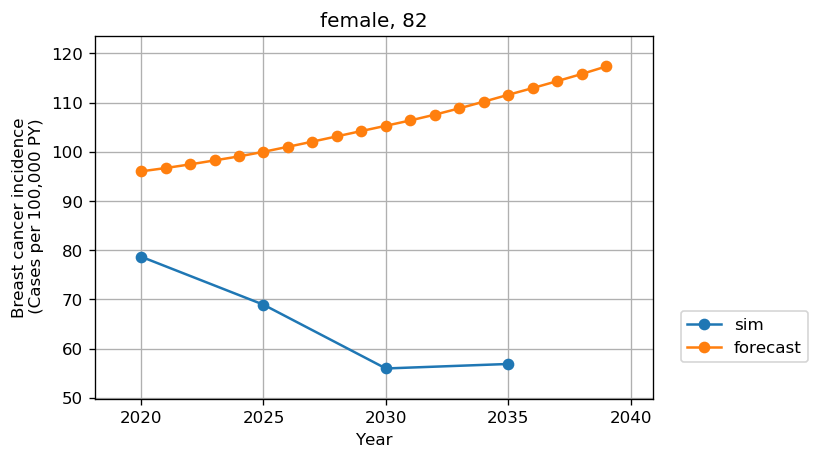

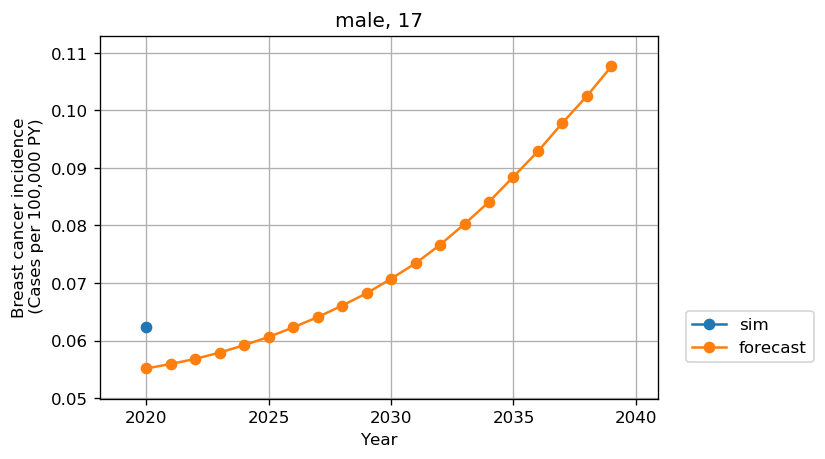

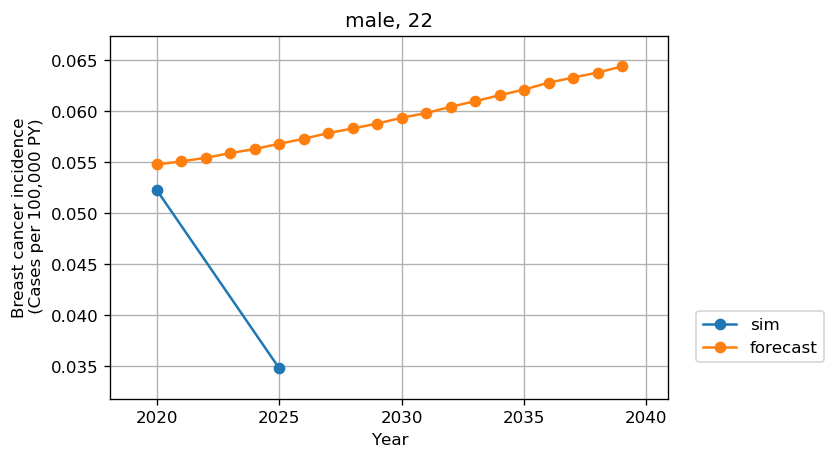

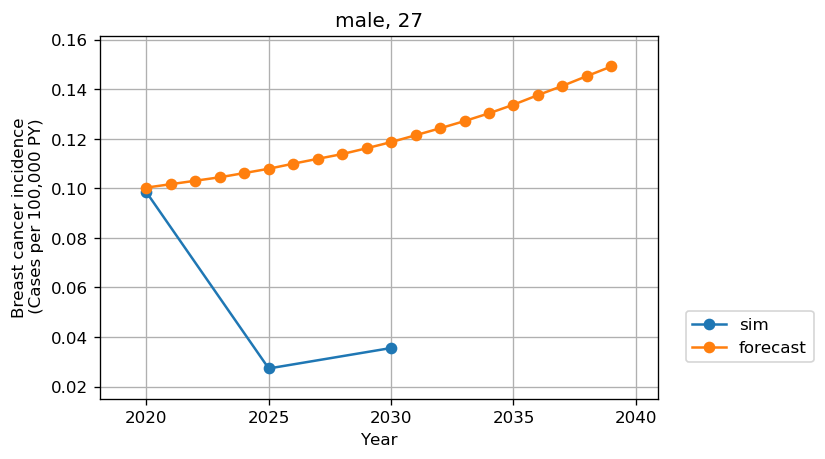

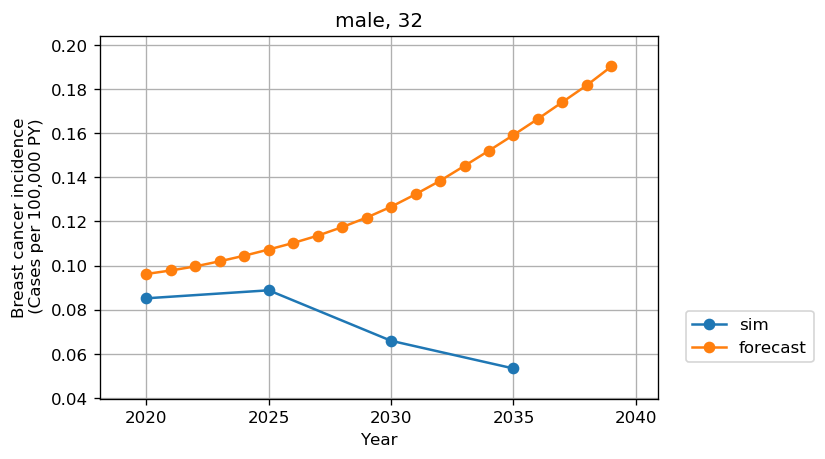

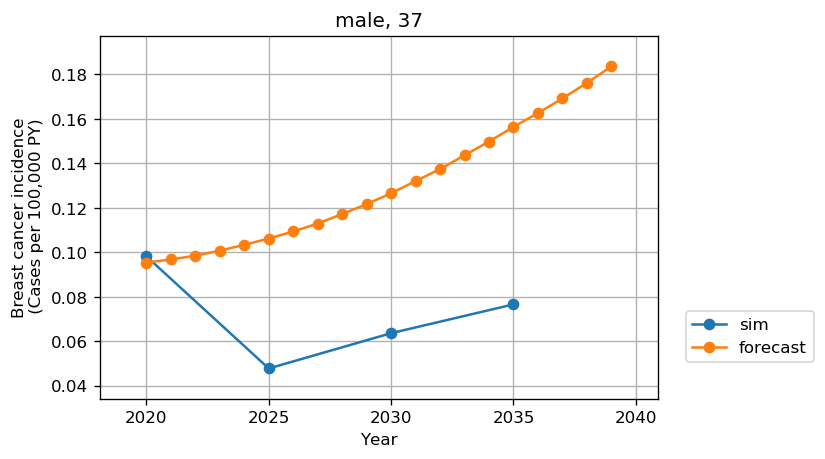

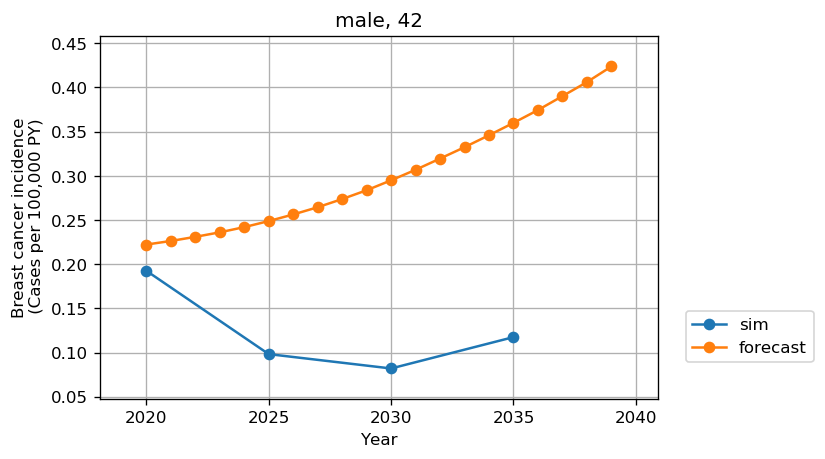

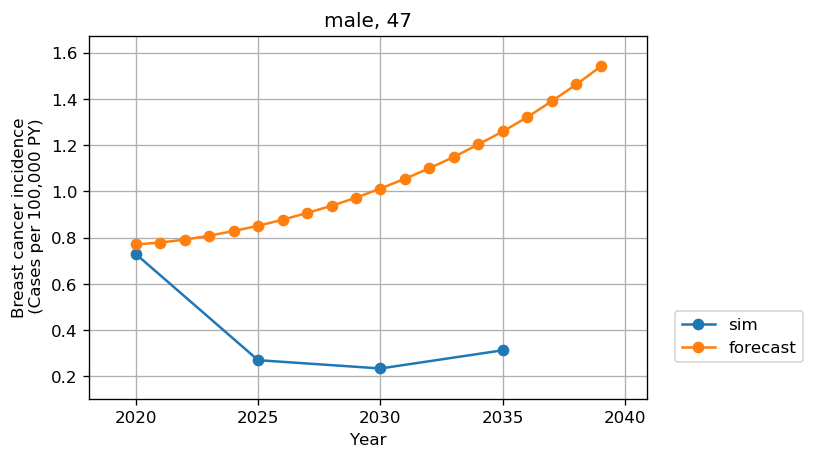

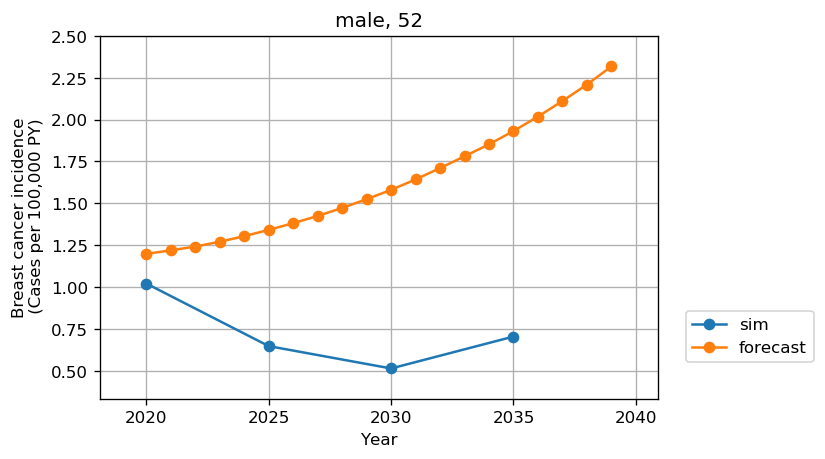

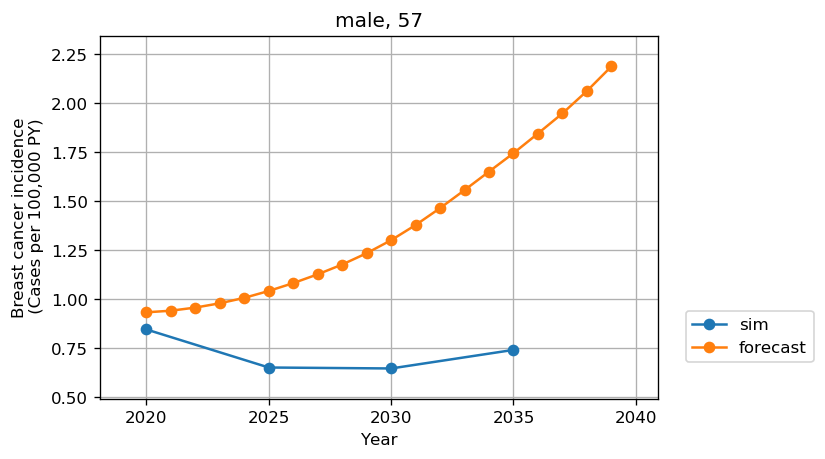

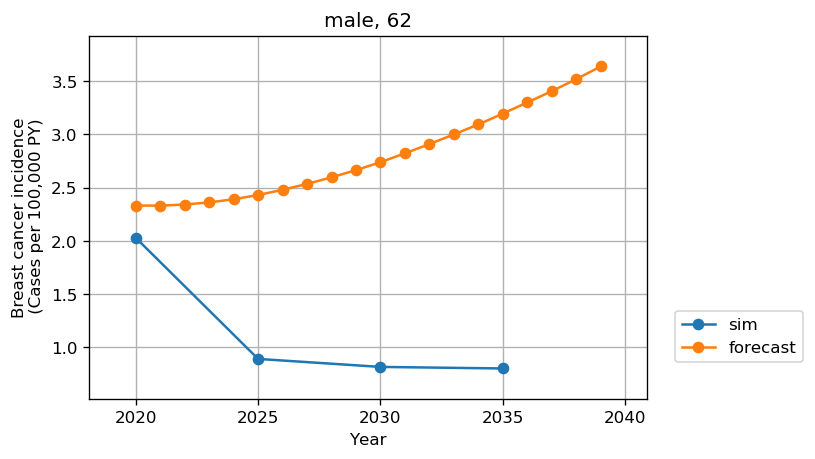

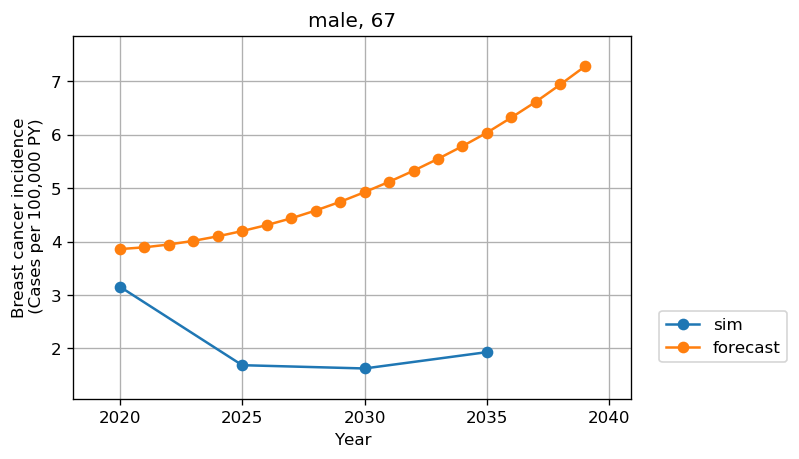

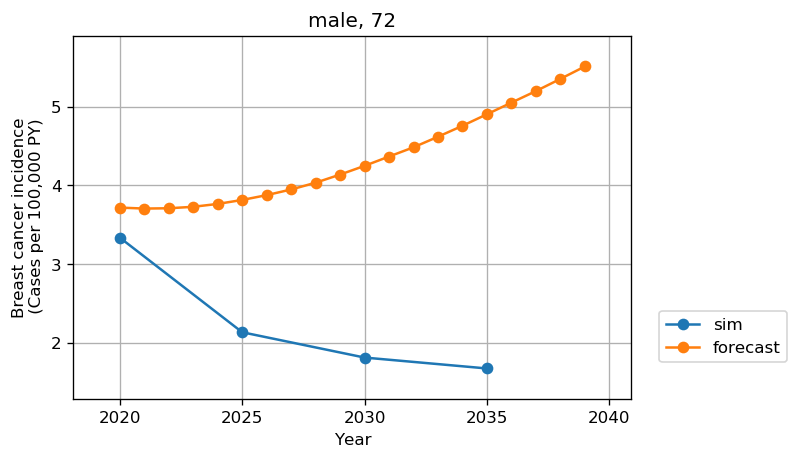

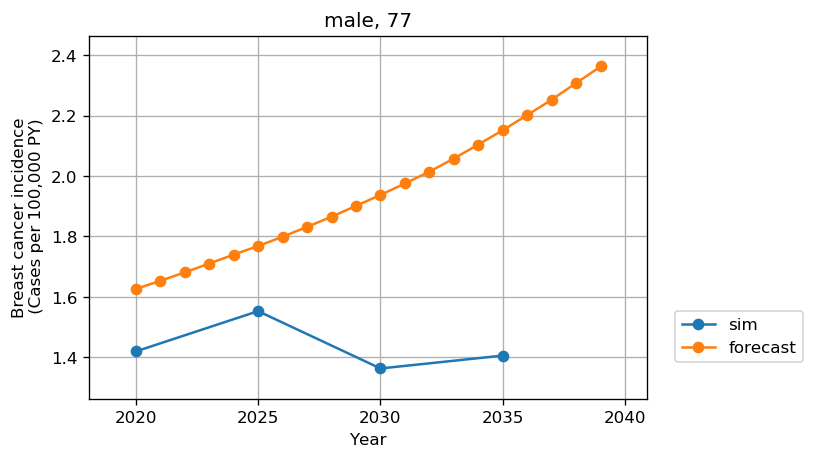

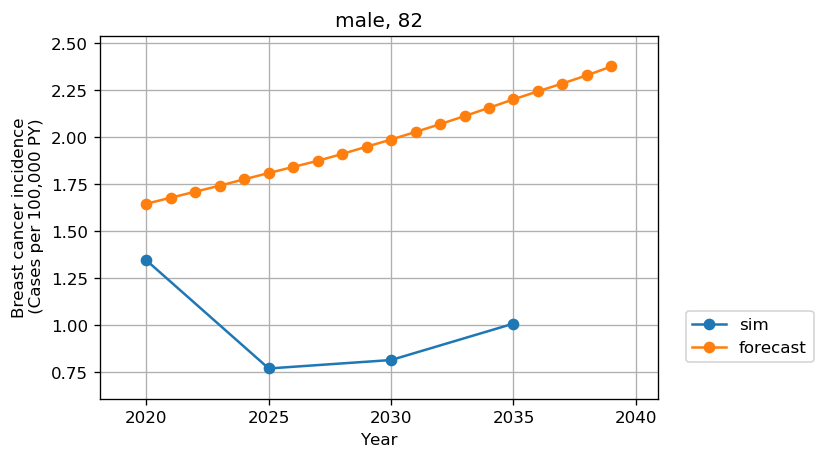

In [15]:
with PdfPages('C:/Users/yongqx2/Desktop/Sim Science/Swiss RE Cancer/breast_cancer_incidence_from_sim_vs_forecast_by_year.pdf') as pdf:
    for sex in ['female', 'male']:
        for age in np.arange(17, 87, 5):
            sim_vs_forecast_by_year(sim_incidence, t, age, sex)
            pdf.savefig(bbox_inches='tight')

In [13]:
# breast cancer incidence in sim vs forecast by age
def sim_vs_forecast_by_age(sim, forecast, sex: str, year):
    sim_sub = sim[(sim.year == year) & (sim.sex == sex)]
    forecast_sub = forecast[(forecast.year == year) & (forecast.sex == sex)]
    
    plt.figure(figsize=(6, 4), dpi=120)
    plt.plot(sim_sub['age_midpoint'], sim_sub['mean'], marker='o', markersize=3, label='sim')
    plt.plot(forecast_sub['age'], forecast_sub['mean'], marker='o', markersize=3, label='forecast')
    plt.title(f'{sex}, {year}')
    plt.xlabel('Age')
    plt.ylabel('Breast cancer incidence\n (Cases per 100,000 PY)')
    plt.legend(loc=(1.05, .1))
    plt.grid()

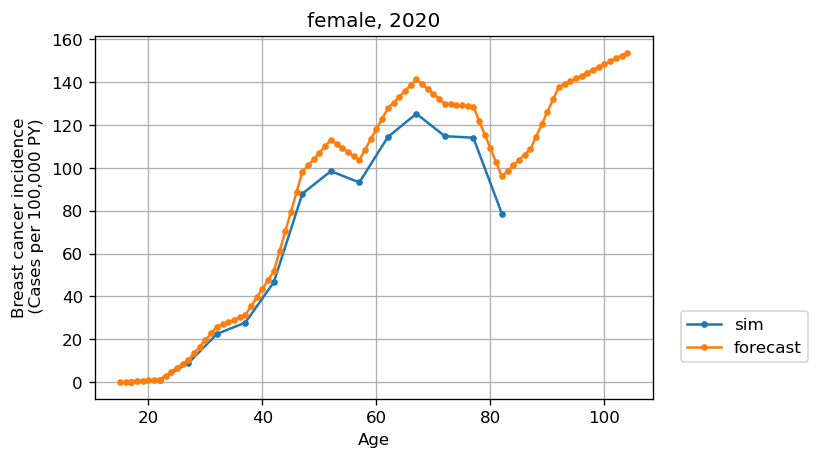

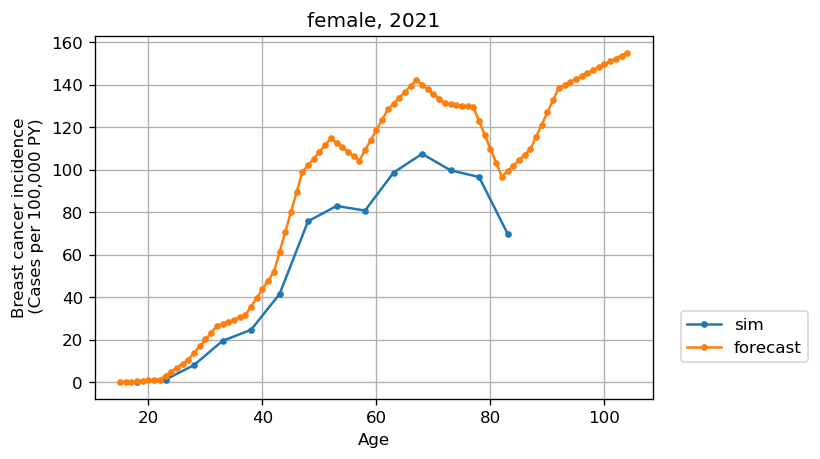

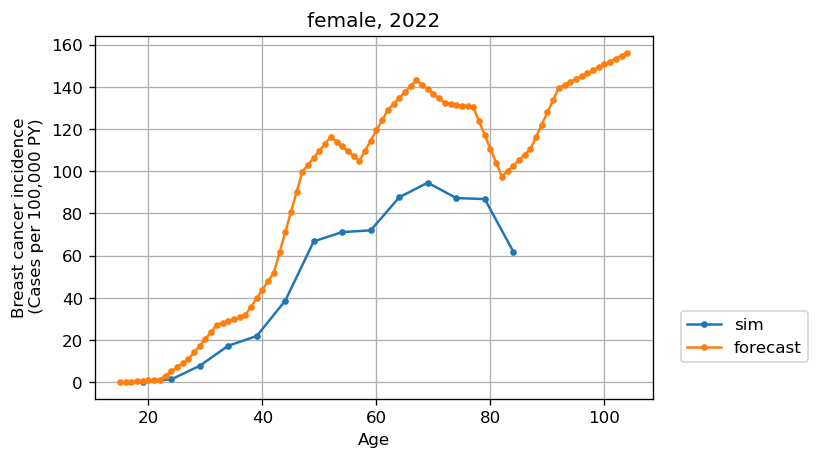

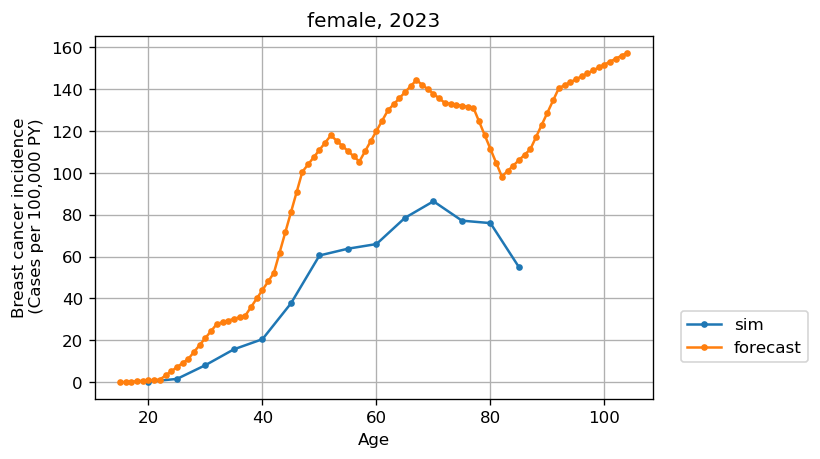

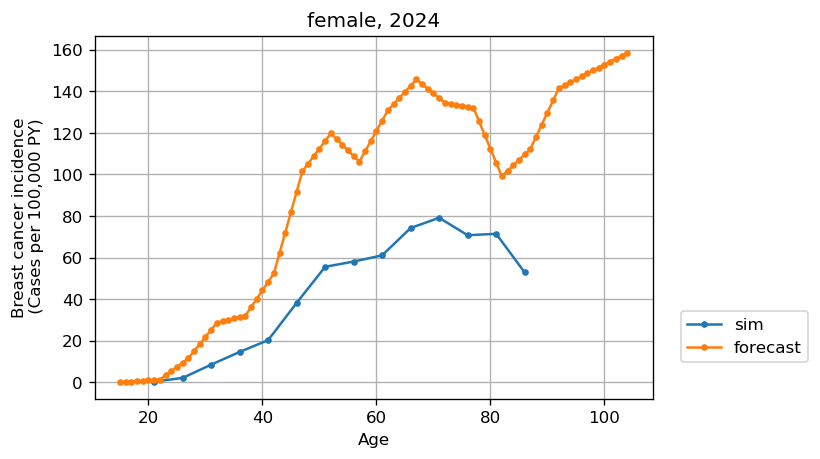

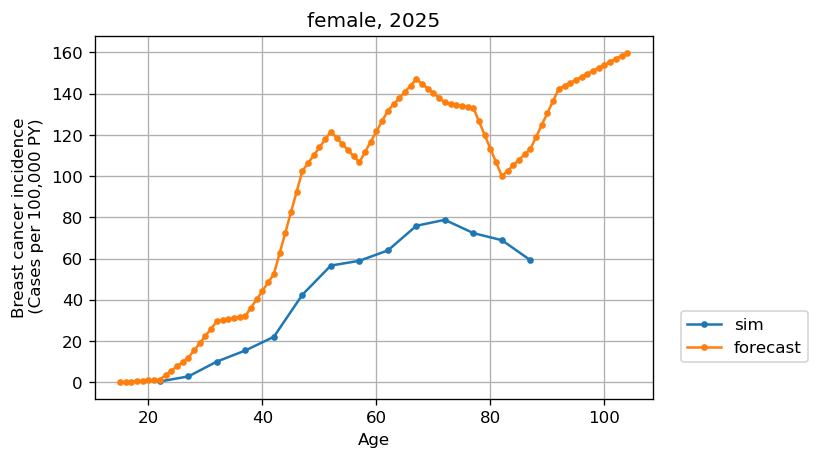

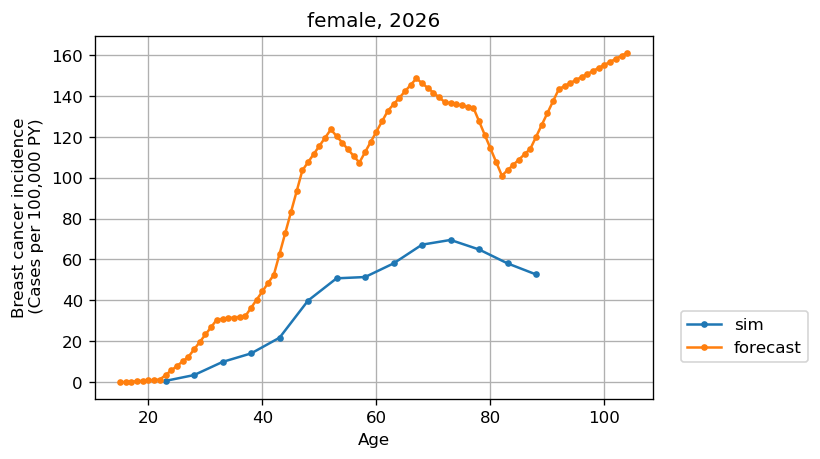

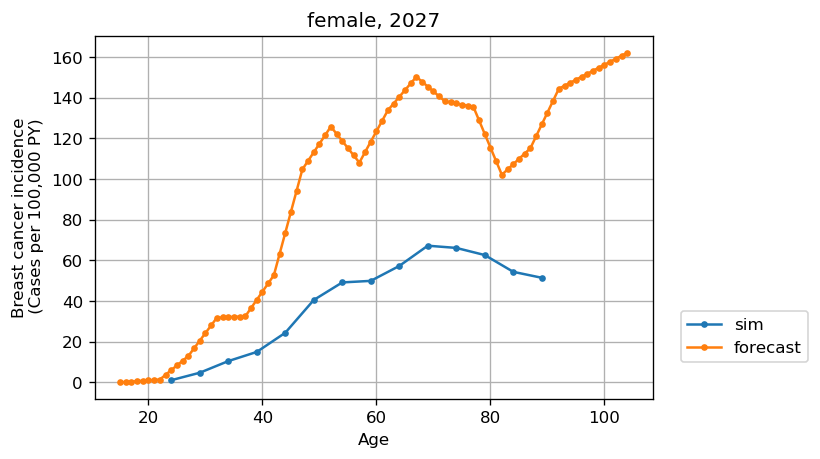

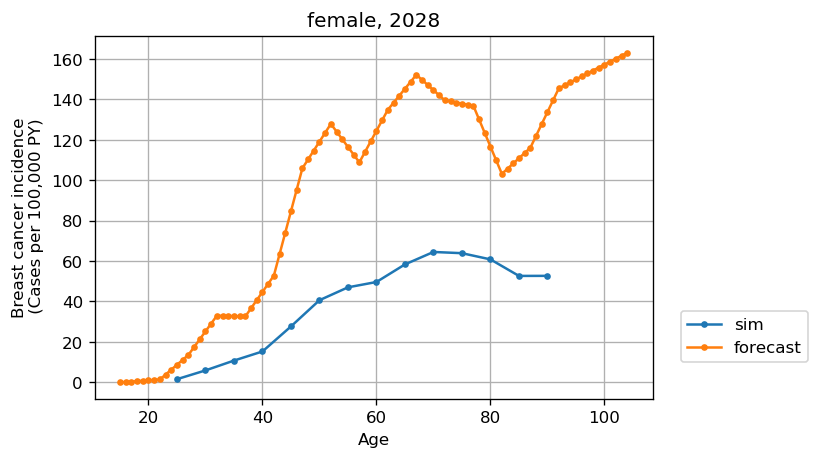

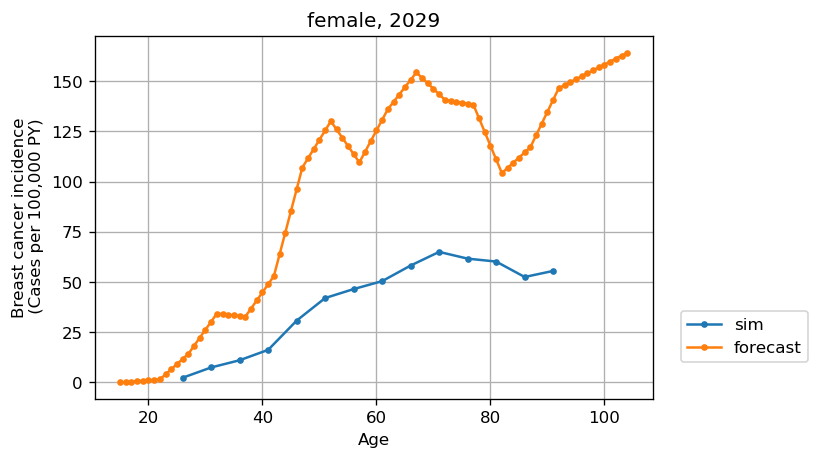

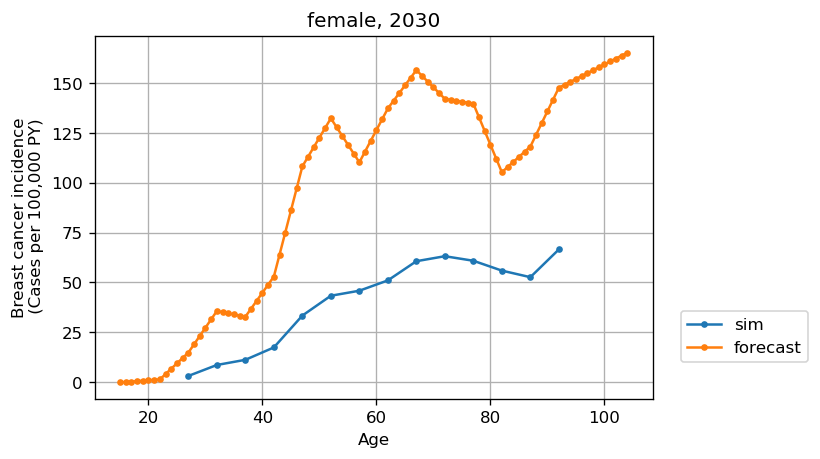

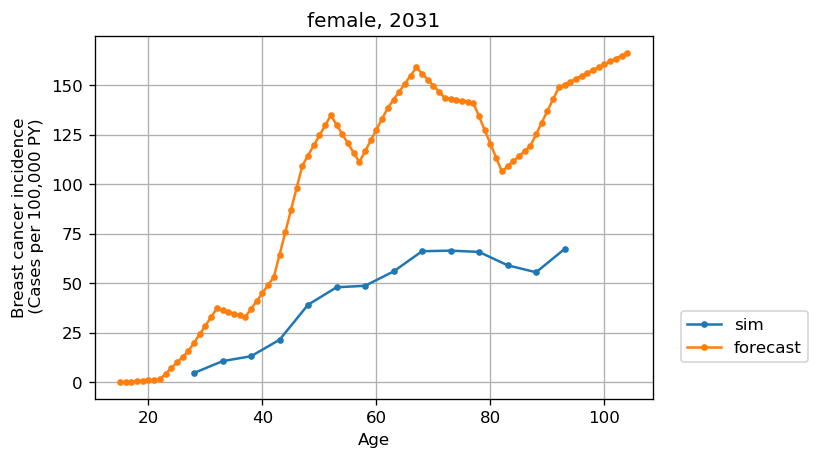

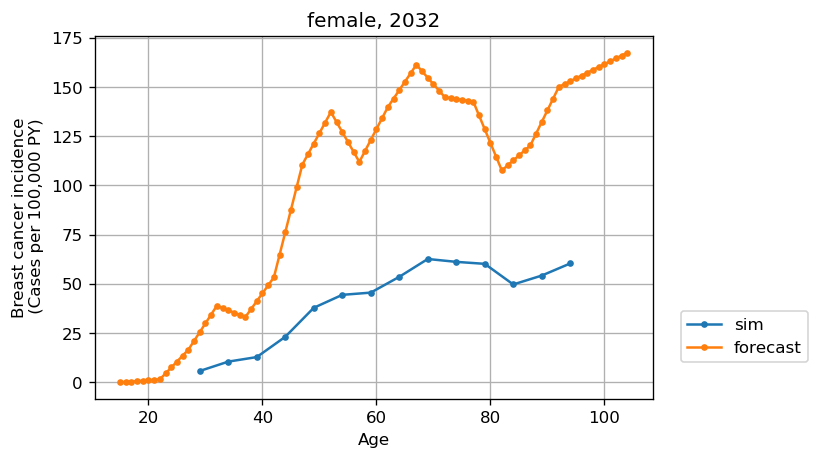

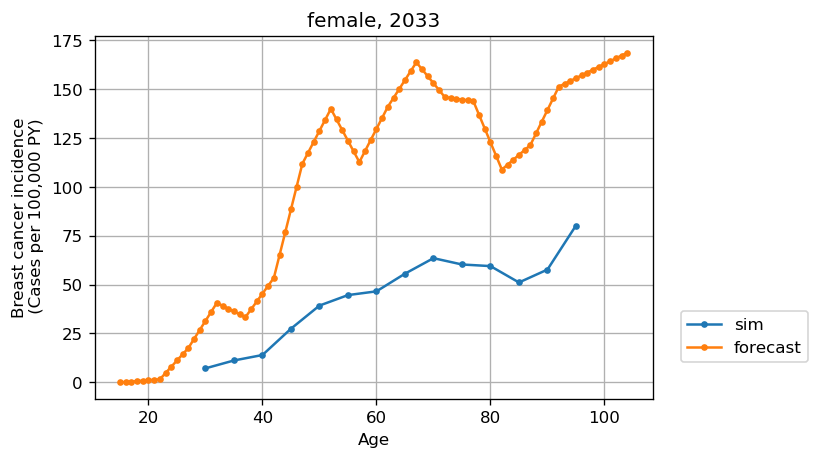

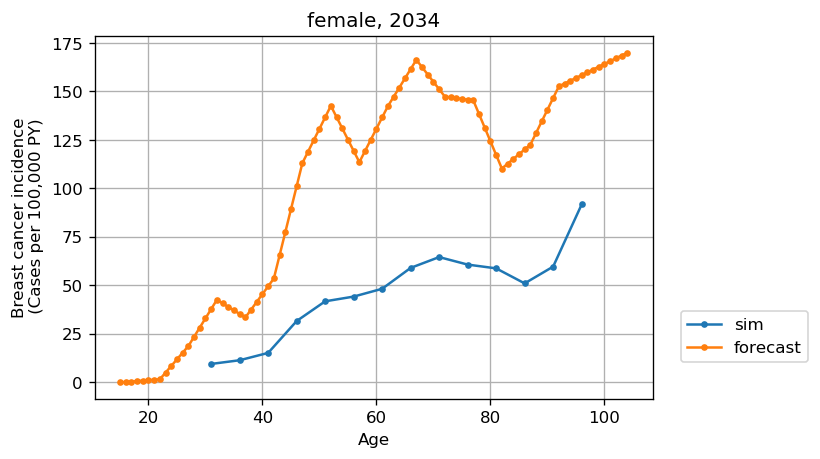

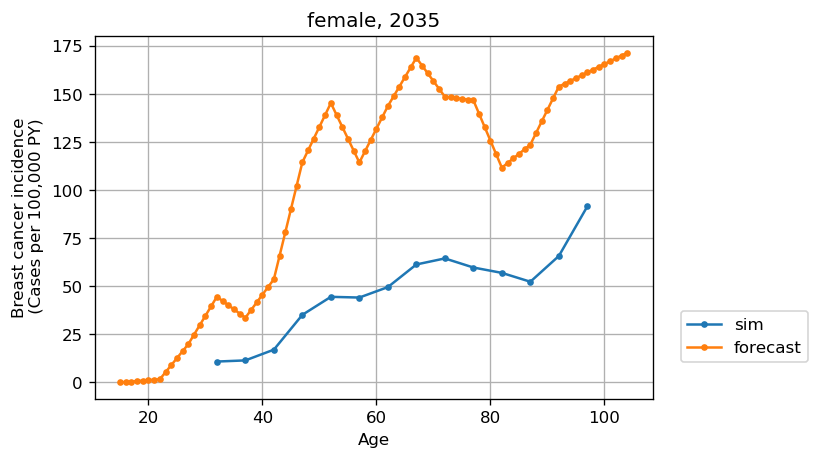

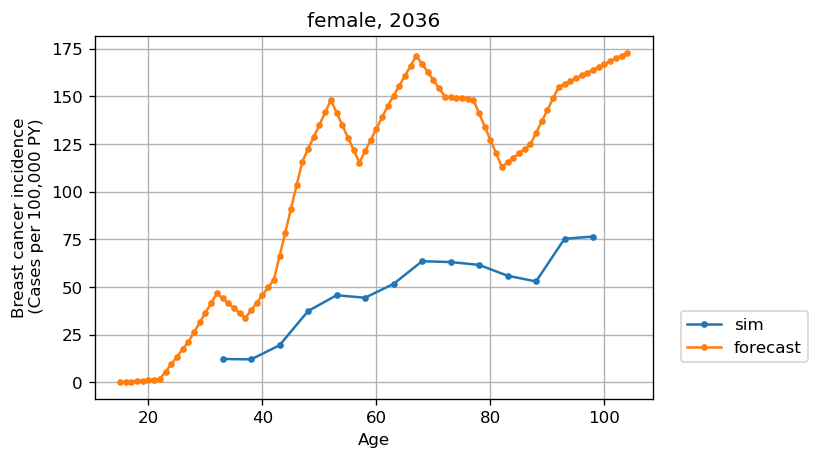

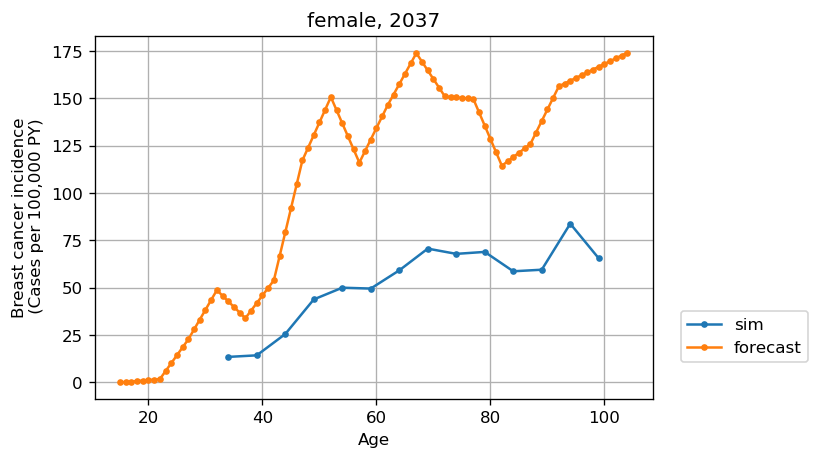

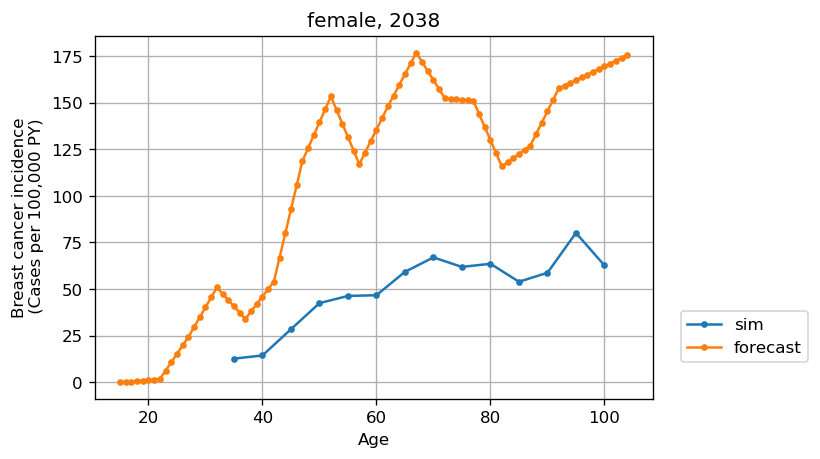

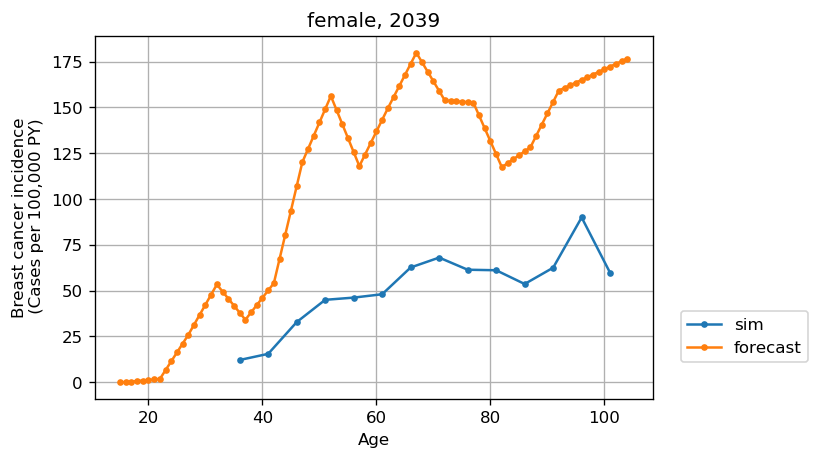

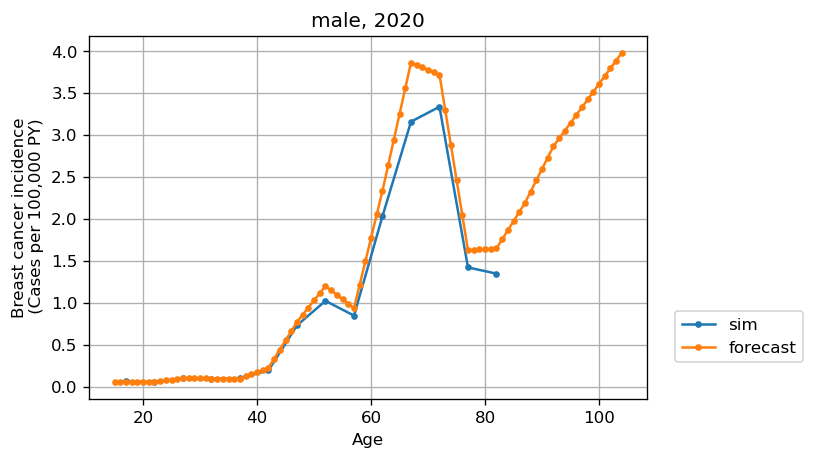

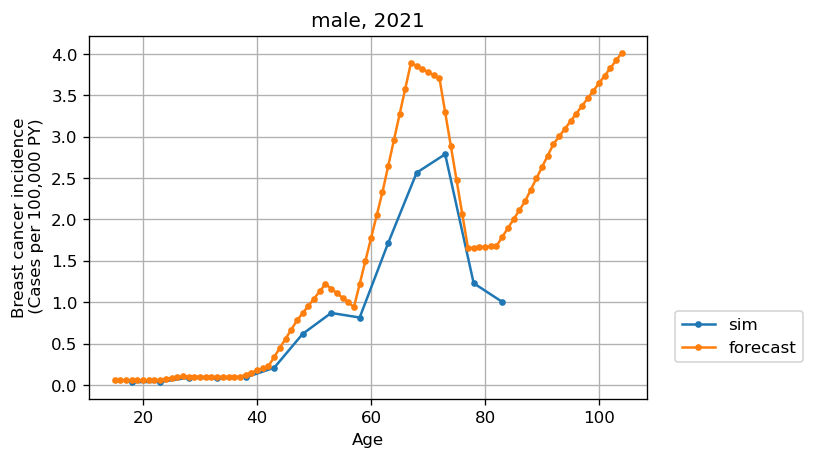

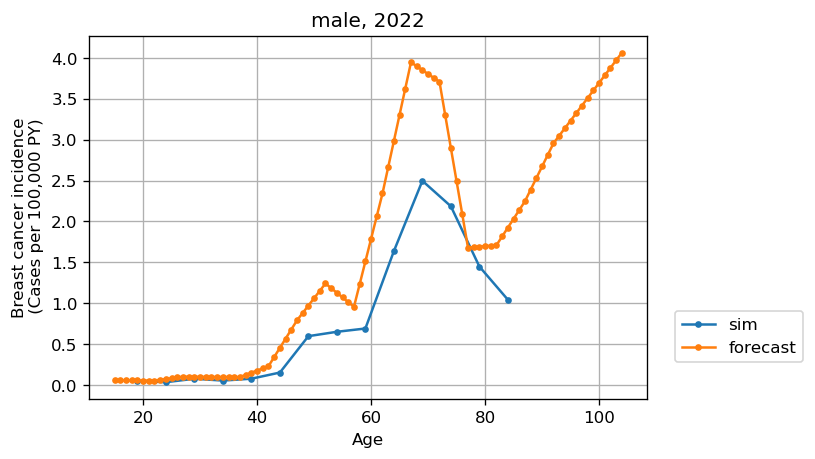

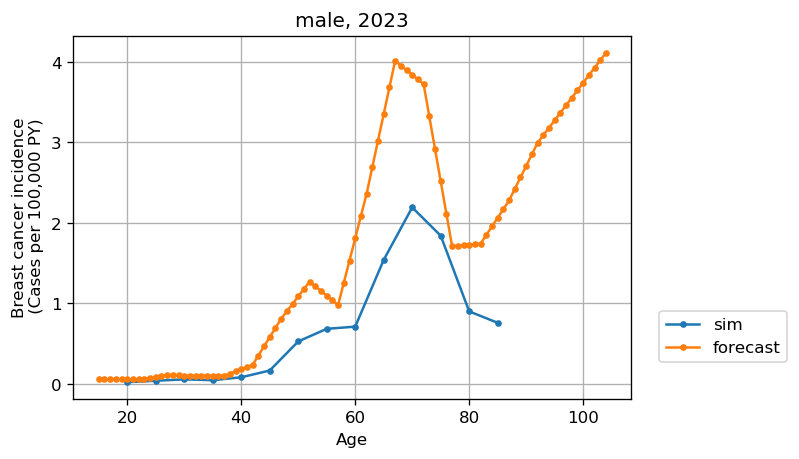

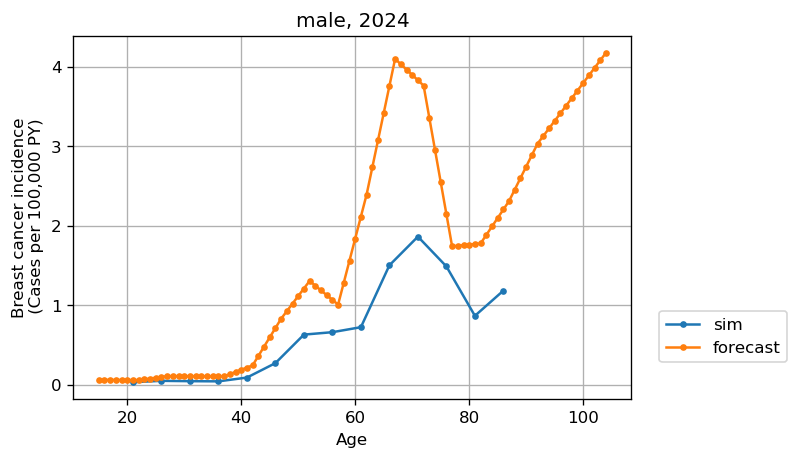

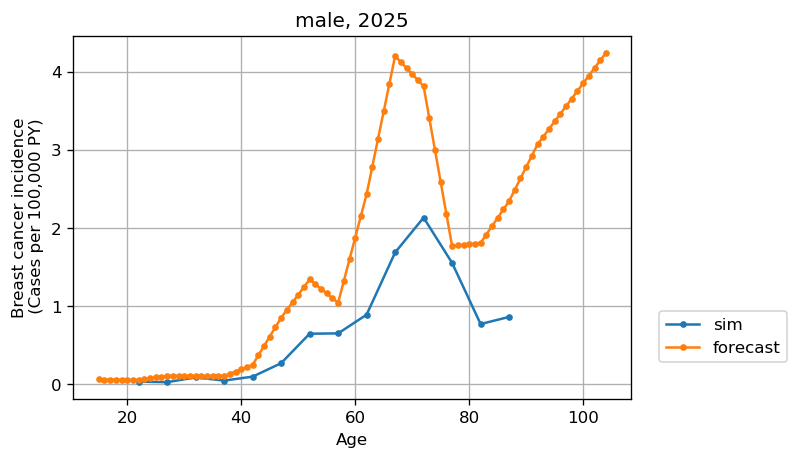

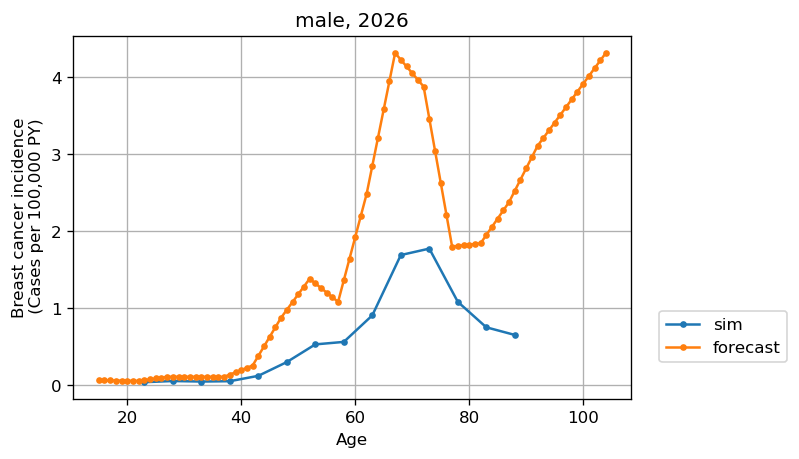

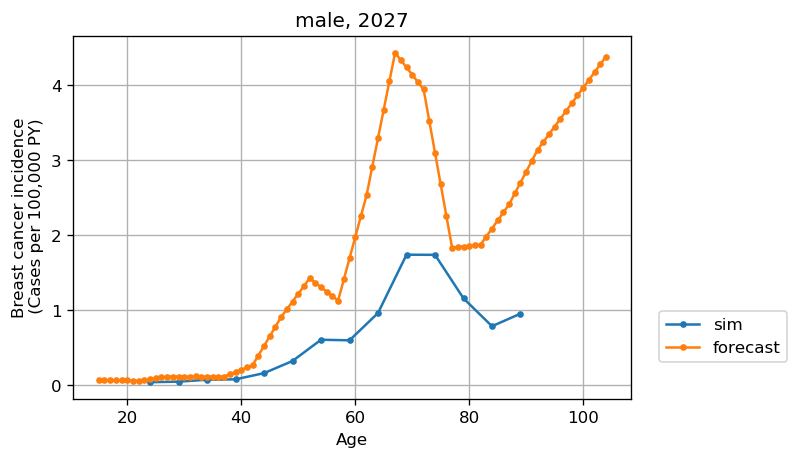

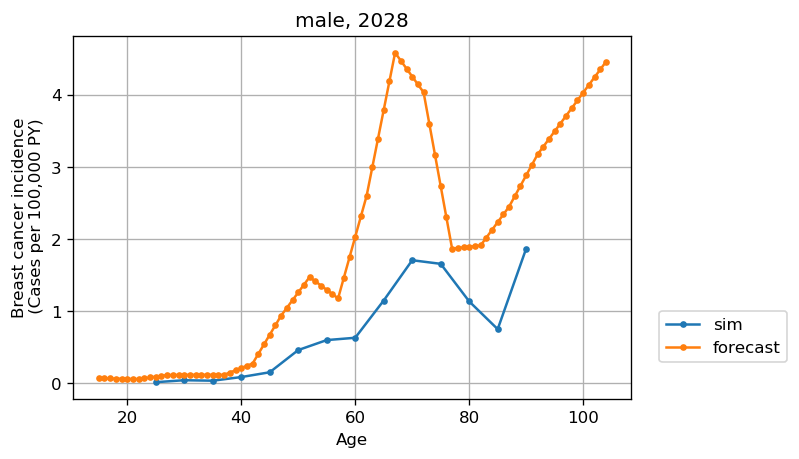

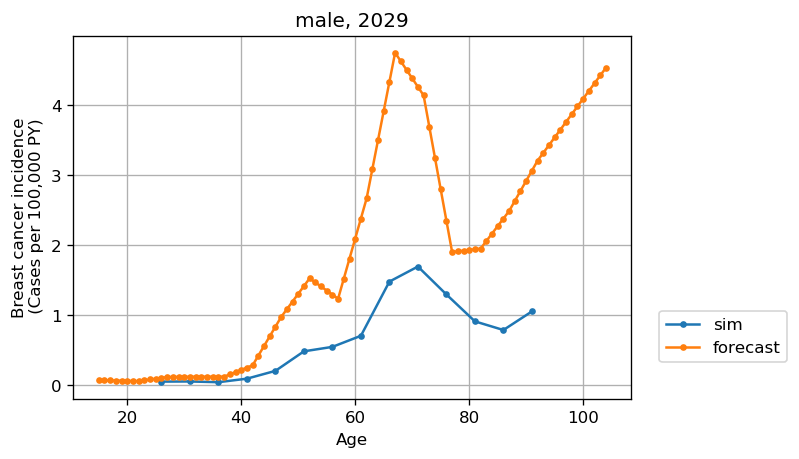

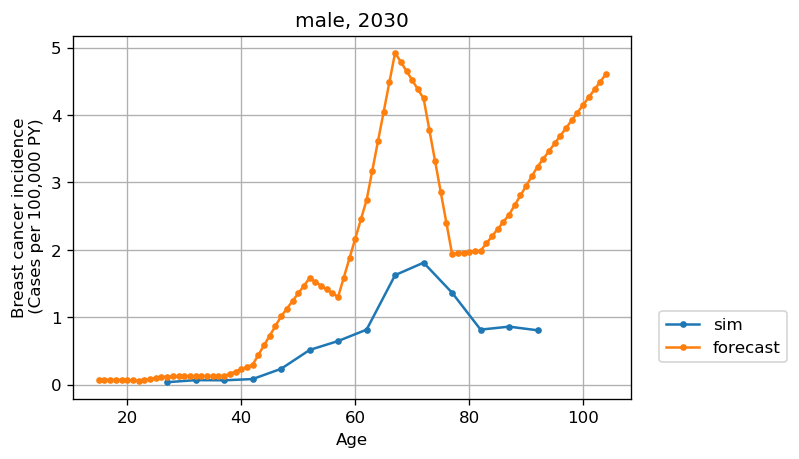

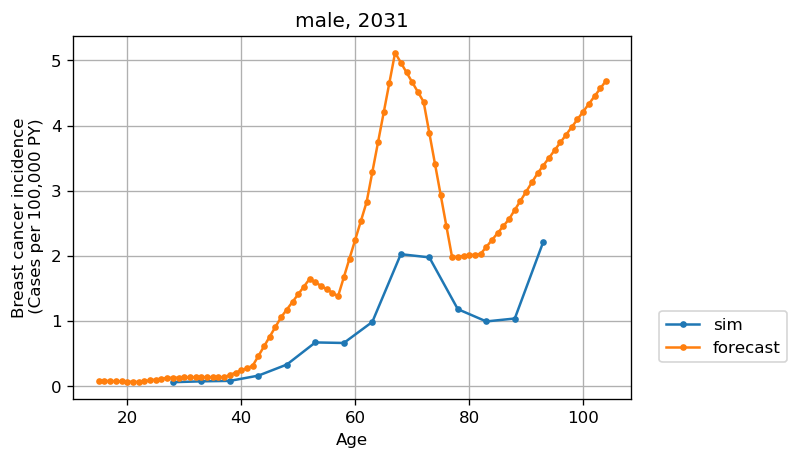

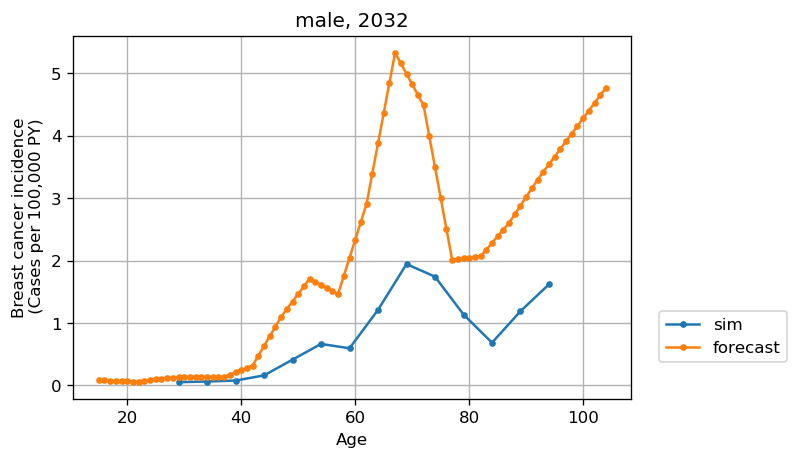

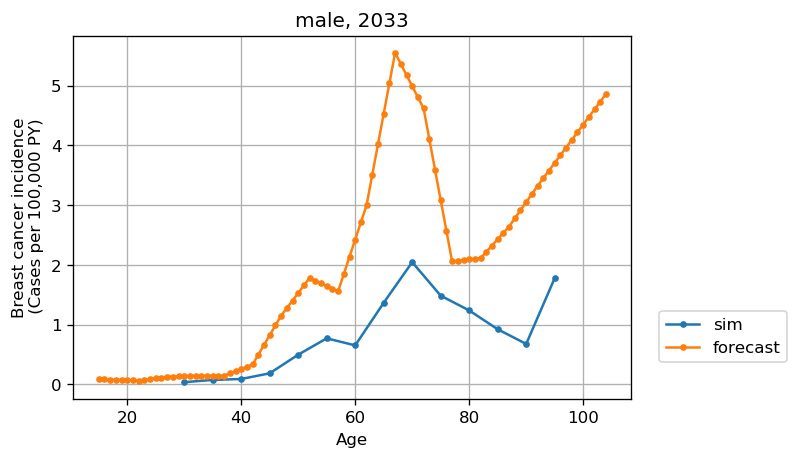

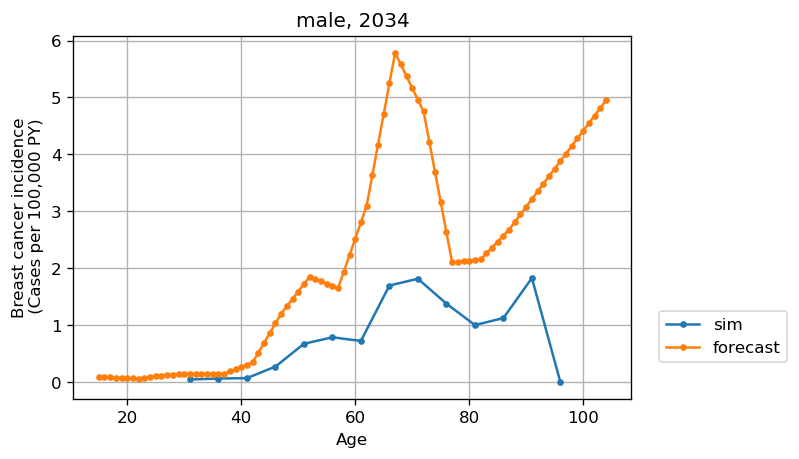

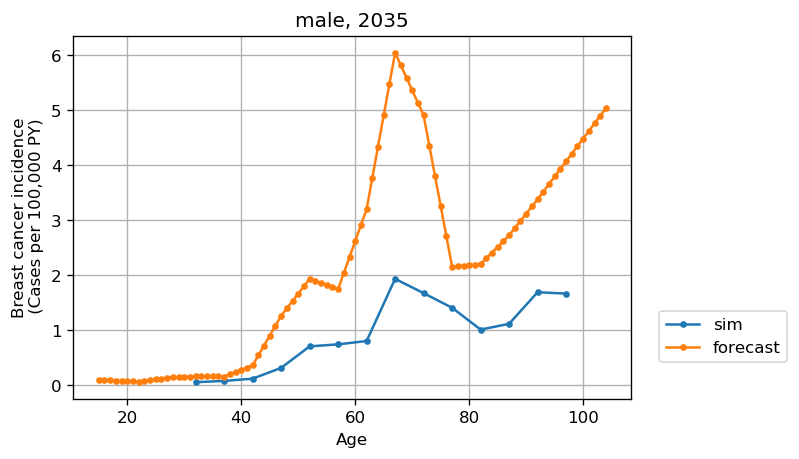

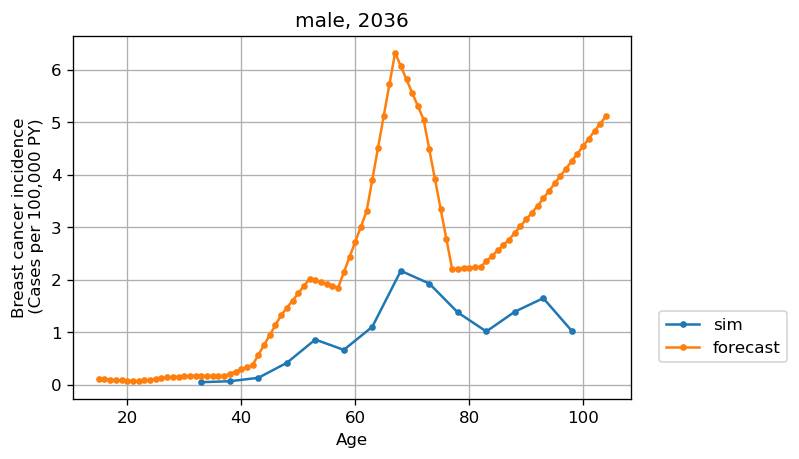

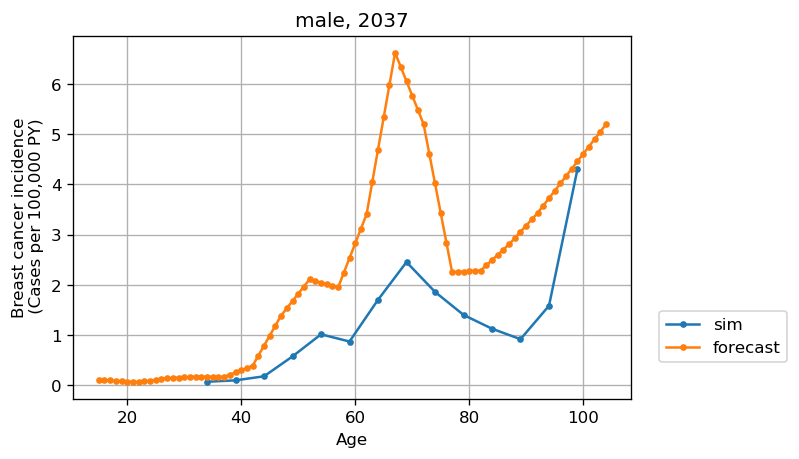

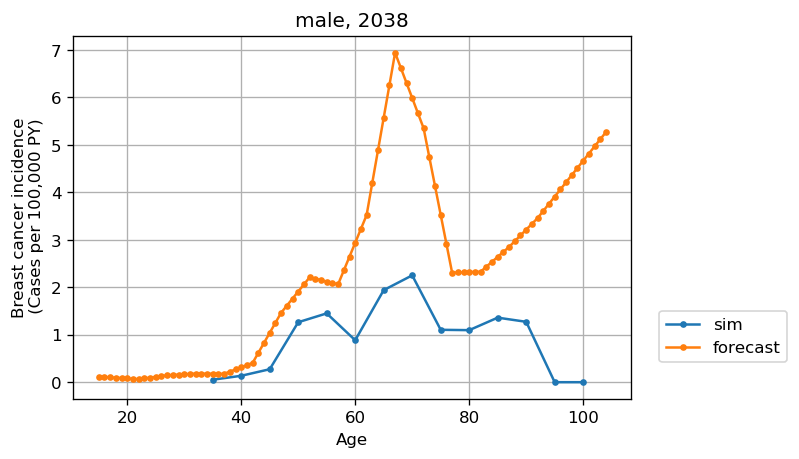

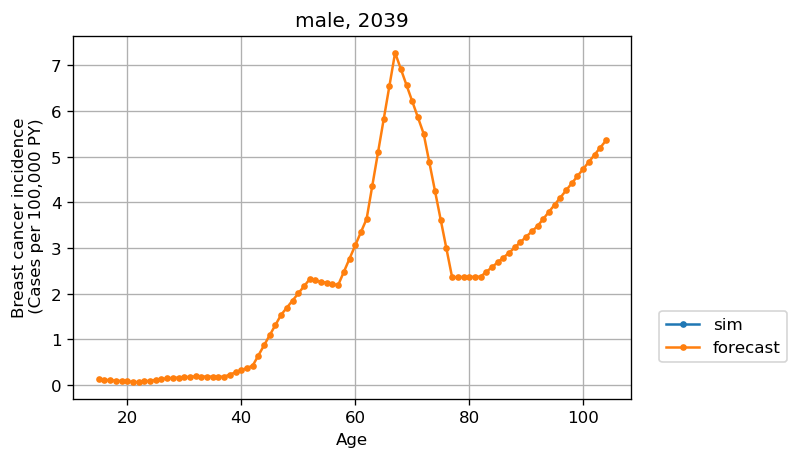

In [16]:
with PdfPages('C:/Users/yongqx2/Desktop/Sim Science/Swiss RE Cancer/breast_cancer_incidence_from_sim_vs_forecast_by_age.pdf') as pdf:
    for sex in ['female', 'male']:
        for year in range(2020, 2040):
            sim_vs_forecast_by_age(sim_incidence, t, sex, year)
            pdf.savefig(bbox_inches='tight')